# DECOY MNIST experiments notebook

### EXCEUTE ONLY FOR GOOGLE COLAB  !

In [1]:
# SETUP STUFF
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the xil program 
FOLDERNAME = "Masterthesis/XIL_experiments/xil_framework"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
pip install captum

In [ ]:
pip install lime

In [ ]:
cd /content/drive/MyDrive/Masterthesis/XIL_experiments/xil_framework/

### Setup notebook

In [5]:
# IMPORTS
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

from learner.models import dnns
from learner.learner import Learner
from data_store.datasets import decoy_mnist, decoy_mnist_rieger, decoy_mnist_CE_augmented
from xil_methods.xil_loss import RRRLoss, CDEPLoss, HINTLoss, RBRLoss
import util
import explainer

In [6]:
# matplot magic
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# HYPERPARAMETERS for every experiment
SEED = 60
SHUFFLE = True
BATCH_SIZE = 256
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 50
SAVE_BEST = True
VERBOSE_AFTER_N_EPOCHS = 2

Using cuda device


### MNIST (no decoy)

Loading dataset from existing file!
Train set


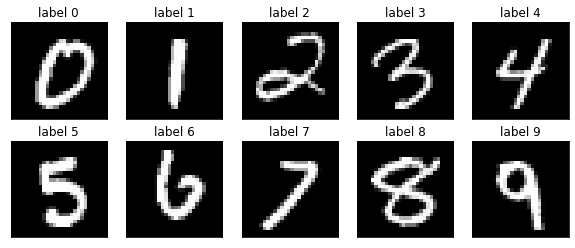

Val set


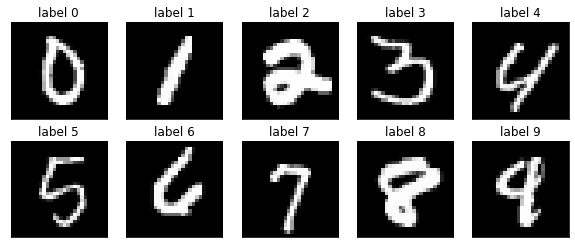

In [7]:
# Load dataloaders
train_dataloader, val_dataloader = decoy_mnist(no_decoy=True, shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE)

# show image and explanation grid training
print("Train set")
util.show_img_grid_mnist(train_dataloader)
# show image and explanation grid val set
print("Val set")
util.show_img_grid_mnist(val_dataloader)


**Simple MLP**

MNIST Simple MLP no XIL -> CrossEntropyLoss:
Start training...
Epoch 2| accuracy: 93.9%, loss: 0.000812 | Test Error: Acc: 94.4%, Avg loss: 0.006139
Epoch 4| accuracy: 96.2%, loss: 0.000499 | Test Error: Acc: 95.5%, Avg loss: 0.006068
Epoch 6| accuracy: 97.1%, loss: 0.000374 | Test Error: Acc: 96.0%, Avg loss: 0.006055
Epoch 8| accuracy: 97.5%, loss: 0.000309 | Test Error: Acc: 96.3%, Avg loss: 0.006018
Epoch 10| accuracy: 97.8%, loss: 0.000270 | Test Error: Acc: 96.4%, Avg loss: 0.006018
Epoch 12| accuracy: 98.0%, loss: 0.000242 | Test Error: Acc: 96.7%, Avg loss: 0.005995
Epoch 14| accuracy: 98.2%, loss: 0.000217 | Test Error: Acc: 96.5%, Avg loss: 0.005998
Epoch 16| accuracy: 98.4%, loss: 0.000195 | Test Error: Acc: 96.1%, Avg loss: 0.006010
Epoch 18| accuracy: 98.7%, loss: 0.000163 | Test Error: Acc: 96.3%, Avg loss: 0.006002
Epoch 20| accuracy: 98.6%, loss: 0.000163 | Test Error: Acc: 96.5%, Avg loss: 0.005993
Epoch 22| accuracy: 99.0%, loss: 0.000123 | Test Error: Acc: 96.6%, Avg

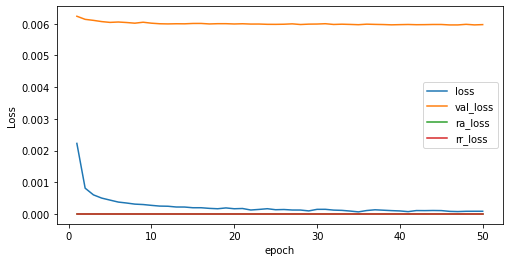

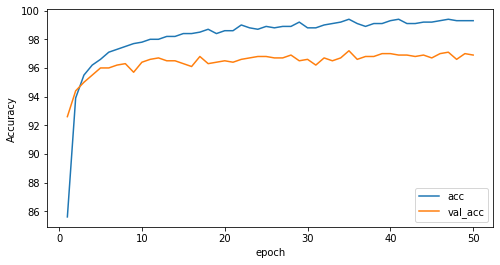

Done!


In [8]:
print("MNIST Simple MLP no XIL -> CrossEntropyLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMlp-Mnist-CEL')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
#learner.load('SimpleMlp-DecoyMnist-CEL.pt')
## evalute on val set
#learner.score(val_dataloader, F.cross_entropy)
print("Done!")

**Simple CNN**

MNIST Simple CNN no XIL -> CrossEntropyLoss:
Start training...
Epoch 2| accuracy: 98.0%, loss: 0.000258 | Test Error: Acc: 98.2%, Avg loss: 0.005948
Epoch 4| accuracy: 98.8%, loss: 0.000144 | Test Error: Acc: 98.7%, Avg loss: 0.005911
Epoch 6| accuracy: 99.2%, loss: 0.000094 | Test Error: Acc: 98.8%, Avg loss: 0.005902
Epoch 8| accuracy: 99.3%, loss: 0.000084 | Test Error: Acc: 98.8%, Avg loss: 0.005898
Epoch 10| accuracy: 99.4%, loss: 0.000064 | Test Error: Acc: 98.9%, Avg loss: 0.005895
Epoch 12| accuracy: 99.5%, loss: 0.000053 | Test Error: Acc: 98.9%, Avg loss: 0.005891
Epoch 14| accuracy: 99.6%, loss: 0.000049 | Test Error: Acc: 98.8%, Avg loss: 0.005903
Epoch 16| accuracy: 99.6%, loss: 0.000048 | Test Error: Acc: 98.9%, Avg loss: 0.005898
Epoch 18| accuracy: 99.7%, loss: 0.000037 | Test Error: Acc: 99.0%, Avg loss: 0.005892
Epoch 20| accuracy: 99.7%, loss: 0.000045 | Test Error: Acc: 99.0%, Avg loss: 0.005888
Epoch 22| accuracy: 99.7%, loss: 0.000038 | Test Error: Acc: 98.9%, Avg

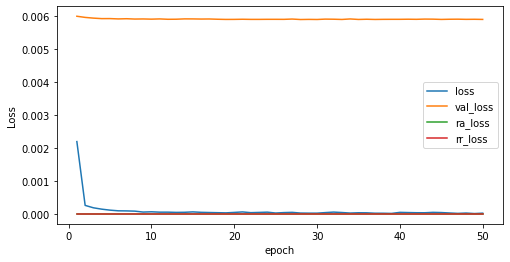

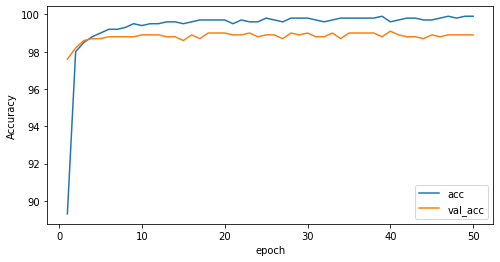

Done!


In [9]:
print("MNIST Simple CNN no XIL -> CrossEntropyLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-Mnist-CEL')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
#learner.load('SimpleMlp-DecoyMnist-CEL.pt')
## evalute on val set
#learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST: 
Load data, visualize it

Loading dataset from existing file!
Train set


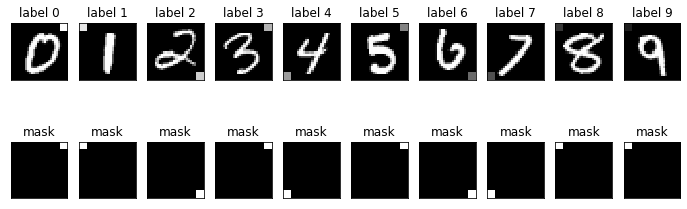

Val set


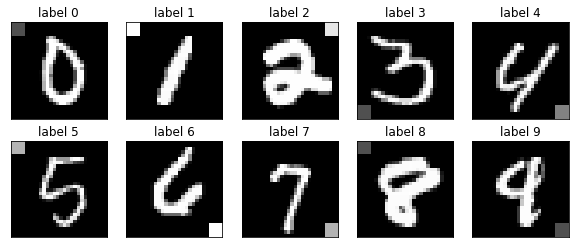

In [10]:
# Load dataloaders
train_dataloader, val_dataloader = decoy_mnist(shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE)

# show image and explanation grid training
print("Train set")
util.show_img_expl_grid_mnist(train_dataloader)
# show image grid val set
print("Val set")
util.show_img_grid_mnist(val_dataloader)


## MLP

### DECOY MNIST -> MLP, NO XIL LOSS

DECOY MNIST Simple MLP no XIL -> CrossEntropyLoss:
Start training...
Epoch 2| accuracy: 96.6%, loss: 0.000423 | Test Error: Acc: 66.3%, Avg loss: 0.007208
Epoch 4| accuracy: 98.1%, loss: 0.000225 | Test Error: Acc: 62.3%, Avg loss: 0.007362
Epoch 6| accuracy: 98.8%, loss: 0.000150 | Test Error: Acc: 62.0%, Avg loss: 0.007363
Epoch 8| accuracy: 99.0%, loss: 0.000118 | Test Error: Acc: 60.2%, Avg loss: 0.007412
Epoch 10| accuracy: 99.1%, loss: 0.000113 | Test Error: Acc: 60.7%, Avg loss: 0.007410
Epoch 12| accuracy: 99.1%, loss: 0.000099 | Test Error: Acc: 60.6%, Avg loss: 0.007402
Epoch 14| accuracy: 99.1%, loss: 0.000106 | Test Error: Acc: 59.8%, Avg loss: 0.007439
Epoch 16| accuracy: 99.3%, loss: 0.000092 | Test Error: Acc: 59.5%, Avg loss: 0.007427
Epoch 18| accuracy: 99.3%, loss: 0.000090 | Test Error: Acc: 59.4%, Avg loss: 0.007453
Epoch 20| accuracy: 99.4%, loss: 0.000078 | Test Error: Acc: 59.6%, Avg loss: 0.007432
Epoch 22| accuracy: 99.3%, loss: 0.000079 | Test Error: Acc: 57.4

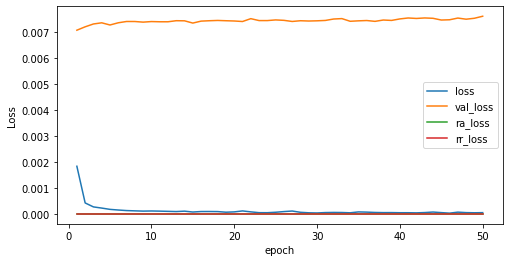

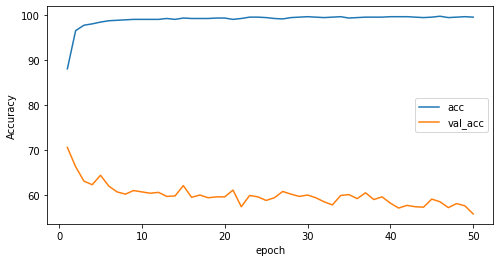

Done!


In [11]:
print("DECOY MNIST Simple MLP no XIL -> CrossEntropyLoss:")
util.set_seed(60)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMlp-DecoyMnist-CEL')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
#learner.load('SimpleMlp-DecoyMnist-CEL.pt')
## evalute on val set
#learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> MLP, XIL LOSS RRR

DECOY MNIST Simple MLP XIL -> RRR Loss:
Start training...
Epoch 2| accuracy: 91.1%, loss: 0.001338 | Test Error: Acc: 92.6%, Avg loss: 0.006280
Epoch 4| accuracy: 94.7%, loss: 0.000775 | Test Error: Acc: 94.4%, Avg loss: 0.006159
Epoch 6| accuracy: 95.7%, loss: 0.000599 | Test Error: Acc: 95.2%, Avg loss: 0.006112
Epoch 8| accuracy: 96.4%, loss: 0.000491 | Test Error: Acc: 95.6%, Avg loss: 0.006073
Epoch 10| accuracy: 96.6%, loss: 0.000442 | Test Error: Acc: 95.8%, Avg loss: 0.006072
Epoch 12| accuracy: 97.3%, loss: 0.000364 | Test Error: Acc: 96.2%, Avg loss: 0.006031
Epoch 14| accuracy: 97.5%, loss: 0.000344 | Test Error: Acc: 95.9%, Avg loss: 0.006040
Epoch 16| accuracy: 97.6%, loss: 0.000319 | Test Error: Acc: 96.1%, Avg loss: 0.006030
Epoch 18| accuracy: 97.8%, loss: 0.000282 | Test Error: Acc: 96.1%, Avg loss: 0.006028
Epoch 20| accuracy: 97.9%, loss: 0.000270 | Test Error: Acc: 96.0%, Avg loss: 0.006030
Epoch 22| accuracy: 98.1%, loss: 0.000252 | Test Error: Acc: 96.0%, Avg loss

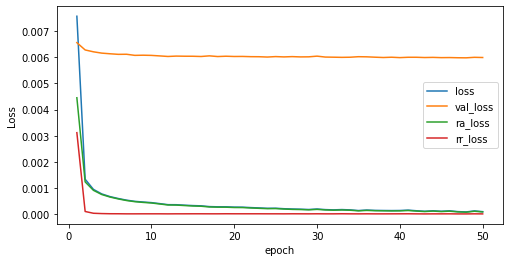

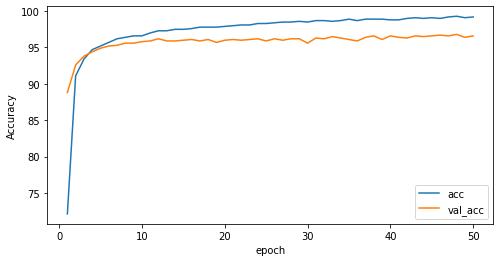

Done!


In [13]:
print("DECOY MNIST Simple MLP XIL -> RRR Loss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = RRRLoss(10) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMlp-DecoyMnist-RRR-reg10')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleMlp-DecoyMnist-RRR.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

MLP DECOY MNIST RRR - IG explanation:


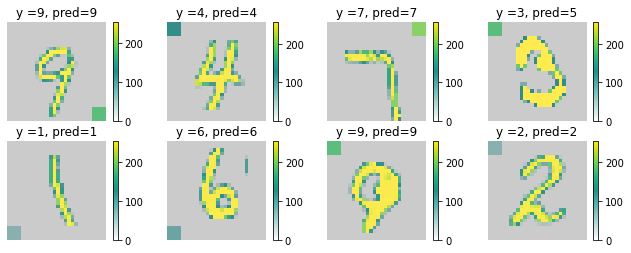

In [14]:
print("MLP DECOY MNIST RRR - IG explanation:")
explainer.explain_with_IG(learner.model, val_dataloader, [i for i in range(8)])

Ross et. al (2017) report: "On this dataset, our model has a higher 99.6% train accuracy but a much lower 55% test accuracy". --> with RRR test acc: 99%

### DECOY MNIST ->  MLP, XIL LOSS RBR

DECOY MNIST Simple MLP XIL -> RBR Loss:
Start training...
Epoch 2| accuracy: 10.4%, loss: 0.106811 | Test Error: Acc: 10.4%, Avg loss: 0.009421
Epoch 4| accuracy: 10.7%, loss: 0.049056 | Test Error: Acc: 10.6%, Avg loss: 0.009357
Epoch 6| accuracy: 16.0%, loss: 0.026289 | Test Error: Acc: 17.3%, Avg loss: 0.009093
Epoch 8| accuracy: 22.8%, loss: 0.014953 | Test Error: Acc: 24.0%, Avg loss: 0.008805
Epoch 10| accuracy: 41.9%, loss: 0.009313 | Test Error: Acc: 47.3%, Avg loss: 0.008247
Epoch 12| accuracy: 59.2%, loss: 0.006719 | Test Error: Acc: 62.7%, Avg loss: 0.007751
Epoch 14| accuracy: 73.2%, loss: 0.004471 | Test Error: Acc: 74.3%, Avg loss: 0.007254
Epoch 16| accuracy: 79.4%, loss: 0.003232 | Test Error: Acc: 79.6%, Avg loss: 0.006972
Epoch 18| accuracy: 82.9%, loss: 0.002593 | Test Error: Acc: 83.3%, Avg loss: 0.006768
Epoch 20| accuracy: 85.6%, loss: 0.002139 | Test Error: Acc: 85.3%, Avg loss: 0.006665
Epoch 22| accuracy: 87.4%, loss: 0.001849 | Test Error: Acc: 86.7%, Avg loss

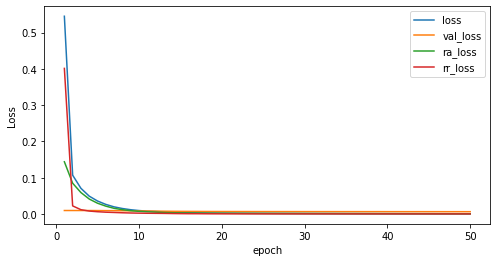

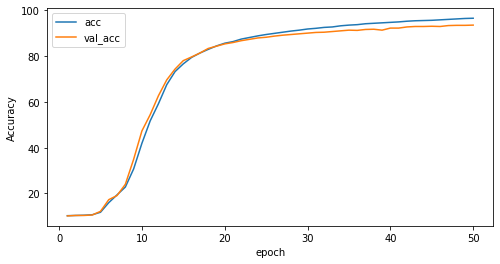

Done!


In [15]:
print("DECOY MNIST Simple MLP XIL -> RBR Loss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = RBRLoss(10000000) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMlp-DecoyMnist-RBR-reg10000000')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleMlp-DecoyMnist-CDEP.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST ->  MLP, XIL LOSS CDEP



DECOY MNIST Simple MLP XIL -> CDEP Loss:
Start training...
Epoch 2| accuracy: 84.9%, loss: 0.001996 | Test Error: Acc: 78.1%, Avg loss: 0.006937
Epoch 4| accuracy: 92.7%, loss: 0.000991 | Test Error: Acc: 77.1%, Avg loss: 0.006889
Epoch 6| accuracy: 95.4%, loss: 0.000631 | Test Error: Acc: 73.8%, Avg loss: 0.006996
Epoch 8| accuracy: 96.5%, loss: 0.000466 | Test Error: Acc: 71.0%, Avg loss: 0.007056
Epoch 10| accuracy: 97.2%, loss: 0.000370 | Test Error: Acc: 68.8%, Avg loss: 0.007153
Epoch 12| accuracy: 97.6%, loss: 0.000307 | Test Error: Acc: 67.4%, Avg loss: 0.007181
Epoch 14| accuracy: 97.9%, loss: 0.000263 | Test Error: Acc: 66.8%, Avg loss: 0.007211
Epoch 16| accuracy: 98.3%, loss: 0.000217 | Test Error: Acc: 66.7%, Avg loss: 0.007189
Epoch 18| accuracy: 98.5%, loss: 0.000182 | Test Error: Acc: 63.9%, Avg loss: 0.007301
Epoch 20| accuracy: 98.8%, loss: 0.000159 | Test Error: Acc: 64.7%, Avg loss: 0.007255
Epoch 22| accuracy: 98.8%, loss: 0.000145 | Test Error: Acc: 62.1%, Avg los

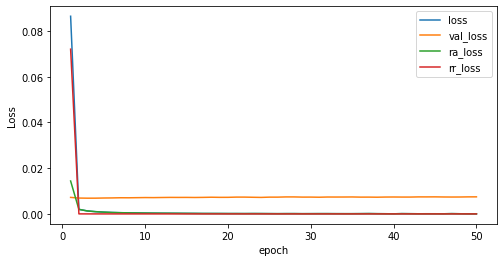

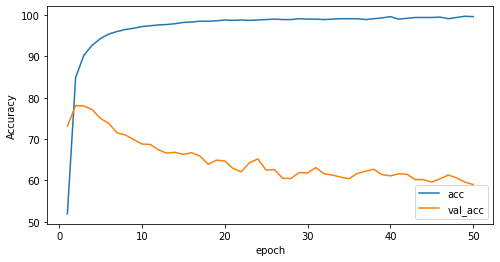

In [16]:
print("DECOY MNIST Simple MLP XIL -> CDEP Loss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = CDEPLoss(1000) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMlp-DecoyMnist-CDEP-reg1000')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleMlp-DecoyMnist-CDEP.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)

### DECOY MNIST -> MLP, XIL Counterexamples (CE)

Loading dataset from existing file!
Train set was augmented: X.size= 120000, y.size= 120000
DECOY MNIST Simple MLP XIL -> CE:
Start training...
Epoch 2| accuracy: 96.1%, loss: 0.000516 | Test Error: Acc: 93.2%, Avg loss: 0.006179
Epoch 4| accuracy: 97.4%, loss: 0.000335 | Test Error: Acc: 94.5%, Avg loss: 0.006097
Epoch 6| accuracy: 97.9%, loss: 0.000252 | Test Error: Acc: 94.6%, Avg loss: 0.006084
Epoch 8| accuracy: 98.2%, loss: 0.000223 | Test Error: Acc: 95.0%, Avg loss: 0.006071
Epoch 10| accuracy: 98.5%, loss: 0.000189 | Test Error: Acc: 94.9%, Avg loss: 0.006072
Epoch 12| accuracy: 98.6%, loss: 0.000165 | Test Error: Acc: 95.6%, Avg loss: 0.006036
Epoch 14| accuracy: 98.7%, loss: 0.000153 | Test Error: Acc: 95.6%, Avg loss: 0.006036
Epoch 16| accuracy: 98.9%, loss: 0.000131 | Test Error: Acc: 95.4%, Avg loss: 0.006041
Epoch 18| accuracy: 98.9%, loss: 0.000132 | Test Error: Acc: 95.7%, Avg loss: 0.006018
Epoch 20| accuracy: 99.1%, loss: 0.000113 | Test Error: Acc: 95.0%, Avg loss:

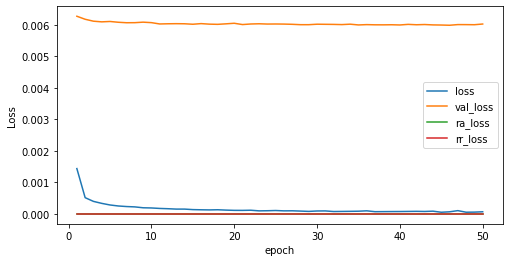

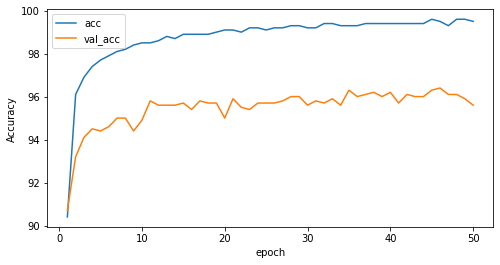

Done!


In [17]:
train_dataloader, val_dataloader = decoy_mnist_CE_augmented(shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE)

print("DECOY MNIST Simple MLP XIL -> CE:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleMlp().to(device)
loss_fn = nn.CrossEntropyLoss() # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleMLP-DecoyMnist-CE-60000aug')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

## CNN

In [18]:
# LOAD the non augmented dataset again
# Load dataloaders
train_dataloader, val_dataloader = decoy_mnist(shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE)

Loading dataset from existing file!


### DECOY MNIST -> CNN, NO XIL

DECOY MNIST Simple CNN no XIL -> CrossEntropyLoss:
Start training...
Epoch 2| accuracy: 98.0%, loss: 0.000251 | Test Error: Acc: 97.4%, Avg loss: 0.005987
Epoch 4| accuracy: 99.0%, loss: 0.000121 | Test Error: Acc: 97.4%, Avg loss: 0.005967
Epoch 6| accuracy: 99.4%, loss: 0.000072 | Test Error: Acc: 97.2%, Avg loss: 0.005978
Epoch 8| accuracy: 99.6%, loss: 0.000048 | Test Error: Acc: 95.3%, Avg loss: 0.006033
Epoch 10| accuracy: 99.7%, loss: 0.000037 | Test Error: Acc: 93.1%, Avg loss: 0.006121
Epoch 12| accuracy: 99.7%, loss: 0.000031 | Test Error: Acc: 90.6%, Avg loss: 0.006222
Epoch 14| accuracy: 99.8%, loss: 0.000021 | Test Error: Acc: 89.3%, Avg loss: 0.006277
Epoch 16| accuracy: 99.8%, loss: 0.000025 | Test Error: Acc: 86.3%, Avg loss: 0.006399
Epoch 18| accuracy: 99.8%, loss: 0.000028 | Test Error: Acc: 82.2%, Avg loss: 0.006546
Epoch 20| accuracy: 99.8%, loss: 0.000027 | Test Error: Acc: 82.7%, Avg loss: 0.006522
Epoch 22| accuracy: 99.8%, loss: 0.000028 | Test Error: Acc: 82.3

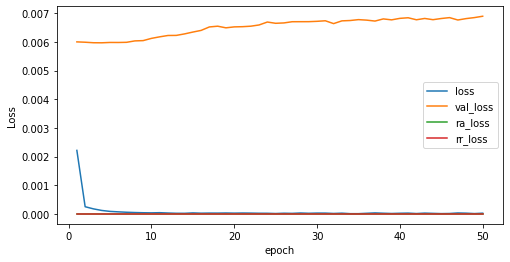

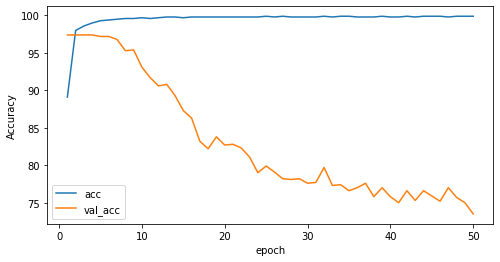

Done!


In [19]:
print("DECOY MNIST Simple CNN no XIL -> CrossEntropyLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = nn.CrossEntropyLoss() # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-CEL')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> CNN, XIL Loss RRR


DECOY MNIST Simple CNN XIL -> RRRLoss:
Start training...
Epoch 2| accuracy: 97.8%, loss: 0.000313 | Test Error: Acc: 97.9%, Avg loss: 0.005955
Epoch 4| accuracy: 98.8%, loss: 0.000167 | Test Error: Acc: 98.7%, Avg loss: 0.005913
Epoch 6| accuracy: 99.1%, loss: 0.000125 | Test Error: Acc: 98.8%, Avg loss: 0.005908
Epoch 8| accuracy: 99.3%, loss: 0.000092 | Test Error: Acc: 98.5%, Avg loss: 0.005914
Epoch 10| accuracy: 99.4%, loss: 0.000085 | Test Error: Acc: 98.6%, Avg loss: 0.005910
Epoch 12| accuracy: 99.5%, loss: 0.000067 | Test Error: Acc: 98.6%, Avg loss: 0.005906
Epoch 14| accuracy: 99.5%, loss: 0.000073 | Test Error: Acc: 98.6%, Avg loss: 0.005915
Epoch 16| accuracy: 99.6%, loss: 0.000053 | Test Error: Acc: 98.9%, Avg loss: 0.005895
Epoch 18| accuracy: 99.7%, loss: 0.000052 | Test Error: Acc: 98.9%, Avg loss: 0.005891
Epoch 20| accuracy: 99.6%, loss: 0.000056 | Test Error: Acc: 98.7%, Avg loss: 0.005900
Epoch 22| accuracy: 99.7%, loss: 0.000043 | Test Error: Acc: 98.8%, Avg loss:

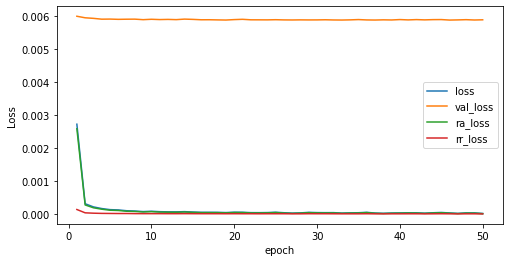

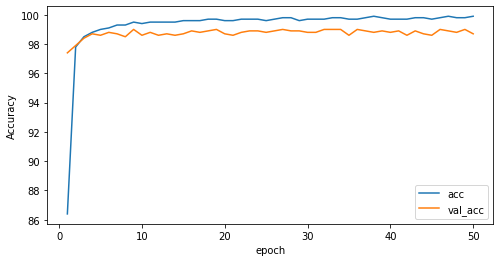

Done!


In [20]:
print("DECOY MNIST Simple CNN XIL -> RRRLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = RRRLoss(10) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-RRR-reg10')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

CNN DECOY MNIST RRR - IG explanation:


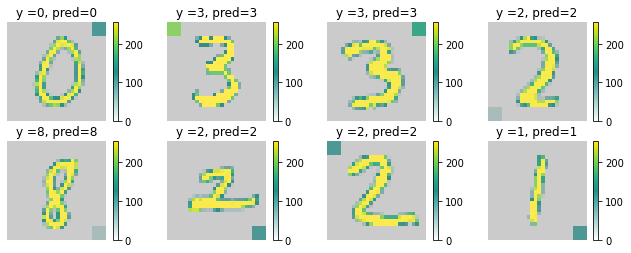

CNN DECOY MNIST RRR - GradCAM explanation:


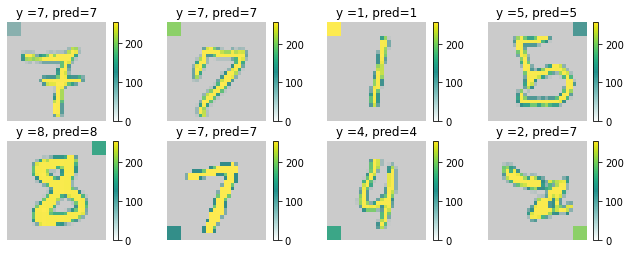

In [21]:
print("CNN DECOY MNIST RRR - IG explanation:")
explainer.explain_with_IG(learner.model, val_dataloader, [i for i in range(8)])
print("CNN DECOY MNIST RRR - GradCAM explanation:")
explainer.explain_with_GradCam(learner.model, val_dataloader, [i for i in range(8)])

### DECOY MNIST -> CNN, XIL Loss RBR

DECOY MNIST Simple CNN XIL -> RBRLoss:
Start training...
Epoch 2| accuracy: 97.9%, loss: 0.000278 | Test Error: Acc: 98.0%, Avg loss: 0.005956
Epoch 4| accuracy: 98.9%, loss: 0.000146 | Test Error: Acc: 98.9%, Avg loss: 0.005906
Epoch 6| accuracy: 99.2%, loss: 0.000103 | Test Error: Acc: 98.9%, Avg loss: 0.005901
Epoch 8| accuracy: 99.5%, loss: 0.000073 | Test Error: Acc: 98.7%, Avg loss: 0.005905
Epoch 10| accuracy: 99.7%, loss: 0.000046 | Test Error: Acc: 99.1%, Avg loss: 0.005890
Epoch 12| accuracy: 99.4%, loss: 0.000073 | Test Error: Acc: 98.9%, Avg loss: 0.005897
Epoch 14| accuracy: 99.4%, loss: 0.000074 | Test Error: Acc: 98.5%, Avg loss: 0.005914
Epoch 16| accuracy: 99.8%, loss: 0.000025 | Test Error: Acc: 99.1%, Avg loss: 0.005885
Epoch 18| accuracy: 99.4%, loss: 0.000083 | Test Error: Acc: 98.8%, Avg loss: 0.005898
Epoch 20| accuracy: 99.8%, loss: 0.000026 | Test Error: Acc: 99.1%, Avg loss: 0.005883
Epoch 22| accuracy: 99.0%, loss: 0.000151 | Test Error: Acc: 98.6%, Avg loss:

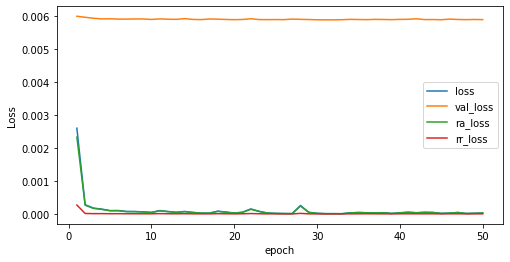

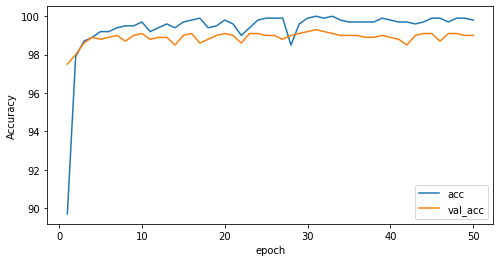

Done!


In [22]:
print("DECOY MNIST Simple CNN XIL -> RBRLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = RBRLoss(10000000) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-RBR-reg10000000')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> CNN, XIL Loss CDEP


DECOY MNIST Simple CNN XIL -> CDEPLoss:
Start training...
Epoch 2| accuracy: 94.4%, loss: 0.000738 | Test Error: Acc: 95.9%, Avg loss: 0.006099
Epoch 4| accuracy: 97.4%, loss: 0.000328 | Test Error: Acc: 97.6%, Avg loss: 0.005992
Epoch 6| accuracy: 98.3%, loss: 0.000212 | Test Error: Acc: 97.6%, Avg loss: 0.005972
Epoch 8| accuracy: 98.8%, loss: 0.000152 | Test Error: Acc: 98.0%, Avg loss: 0.005957
Epoch 10| accuracy: 99.1%, loss: 0.000113 | Test Error: Acc: 97.8%, Avg loss: 0.005956
Epoch 12| accuracy: 99.4%, loss: 0.000076 | Test Error: Acc: 96.7%, Avg loss: 0.006002
Epoch 14| accuracy: 99.6%, loss: 0.000057 | Test Error: Acc: 96.3%, Avg loss: 0.006007
Epoch 16| accuracy: 99.7%, loss: 0.000041 | Test Error: Acc: 95.6%, Avg loss: 0.006041
Epoch 18| accuracy: 99.8%, loss: 0.000024 | Test Error: Acc: 95.2%, Avg loss: 0.006048
Epoch 20| accuracy: 99.7%, loss: 0.000039 | Test Error: Acc: 93.7%, Avg loss: 0.006106
Epoch 22| accuracy: 99.7%, loss: 0.000039 | Test Error: Acc: 91.7%, Avg loss

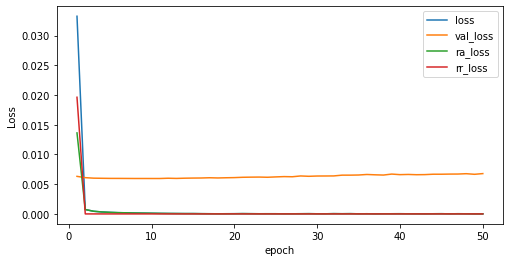

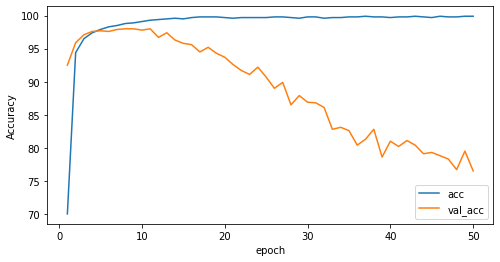

Done!


In [23]:
print("DECOY MNIST Simple CNN XIL -> CDEPLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = CDEPLoss(1000) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-CDEP-reg1000')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> CNN, XIL Counterexamples (CE)

CE n_counterexamples = 1, n_instances=600000 (whole dataset), strategy=random

Loading dataset from existing file!
Train set was augmented: X.size= 120000, y.size= 120000
DECOY MNIST Simple CNN XIL -> CE:
Start training...
Epoch 2| accuracy: 98.9%, loss: 0.000136 | Test Error: Acc: 98.8%, Avg loss: 0.005906
Epoch 4| accuracy: 99.3%, loss: 0.000078 | Test Error: Acc: 98.9%, Avg loss: 0.005898
Epoch 6| accuracy: 99.5%, loss: 0.000052 | Test Error: Acc: 99.0%, Avg loss: 0.005898
Epoch 8| accuracy: 99.6%, loss: 0.000049 | Test Error: Acc: 98.5%, Avg loss: 0.005907
Epoch 10| accuracy: 99.6%, loss: 0.000044 | Test Error: Acc: 99.0%, Avg loss: 0.005889
Epoch 12| accuracy: 99.7%, loss: 0.000043 | Test Error: Acc: 98.9%, Avg loss: 0.005889
Epoch 14| accuracy: 99.7%, loss: 0.000039 | Test Error: Acc: 98.9%, Avg loss: 0.005889
Epoch 16| accuracy: 99.7%, loss: 0.000043 | Test Error: Acc: 98.8%, Avg loss: 0.005894
Epoch 18| accuracy: 99.9%, loss: 0.000017 | Test Error: Acc: 98.4%, Avg loss: 0.005907
Epoch 20| accuracy: 99.7%, loss: 0.000038 | Test Error: Acc: 98.7%, Avg loss:

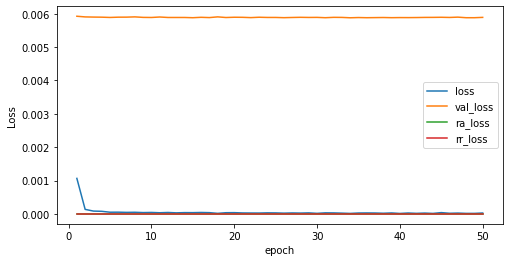

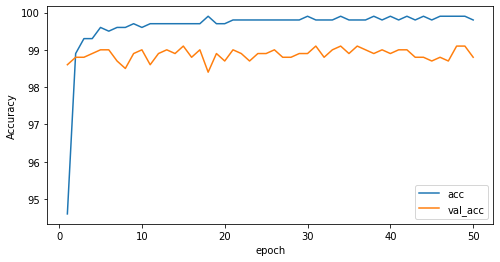

Done!


In [24]:
train_dataloader, val_dataloader = decoy_mnist_CE_augmented(shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE)

print("DECOY MNIST Simple CNN XIL -> CE:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = nn.CrossEntropyLoss() # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-CE-60000aug')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> CNN, XIL loss HINT

Loading dataset from existing file!
Train set


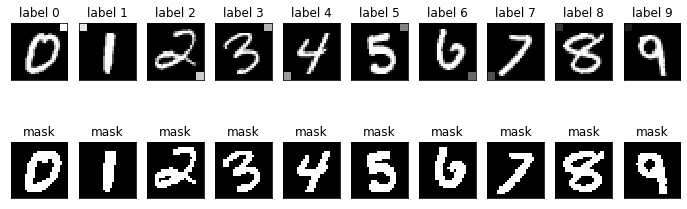

Val set


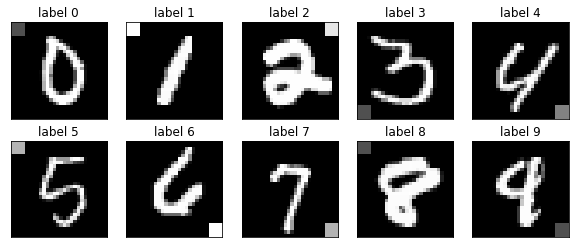

In [25]:
# Load dataloaders with HINT explanations 
train_dataloader, val_dataloader = decoy_mnist(shuffle=SHUFFLE, device=device, batch_size=BATCH_SIZE, hint_expl=True)

# show image and explanation grid training
print("Train set")
util.show_img_expl_grid_mnist(train_dataloader)
# show image and explanation grid val set
print("Val set")
util.show_img_grid_mnist(val_dataloader)


DECOY MNIST Simple CNN XIL -> HINTLoss:
Start training...
Epoch 2| accuracy: 94.3%, loss: 3.431919 | Test Error: Acc: 95.5%, Avg loss: 0.006069
Epoch 4| accuracy: 95.7%, loss: 3.438983 | Test Error: Acc: 95.9%, Avg loss: 0.006060
Epoch 6| accuracy: 96.5%, loss: 3.354206 | Test Error: Acc: 95.5%, Avg loss: 0.006068
Epoch 8| accuracy: 97.1%, loss: 3.287319 | Test Error: Acc: 96.7%, Avg loss: 0.006004
Epoch 10| accuracy: 97.3%, loss: 3.297038 | Test Error: Acc: 96.8%, Avg loss: 0.006012
Epoch 12| accuracy: 97.1%, loss: 3.336116 | Test Error: Acc: 97.2%, Avg loss: 0.005979
Epoch 14| accuracy: 97.2%, loss: 3.324102 | Test Error: Acc: 96.3%, Avg loss: 0.006033
Epoch 16| accuracy: 97.4%, loss: 3.259980 | Test Error: Acc: 96.0%, Avg loss: 0.006056
Epoch 18| accuracy: 97.6%, loss: 3.311939 | Test Error: Acc: 97.4%, Avg loss: 0.005970
Epoch 20| accuracy: 97.4%, loss: 3.305309 | Test Error: Acc: 96.8%, Avg loss: 0.006009
Epoch 22| accuracy: 97.7%, loss: 3.284515 | Test Error: Acc: 97.7%, Avg loss

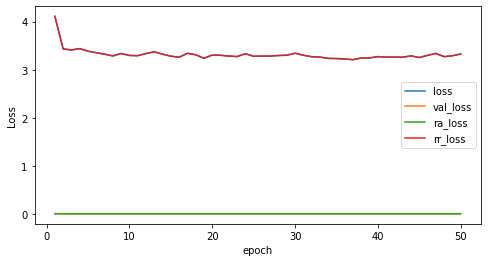

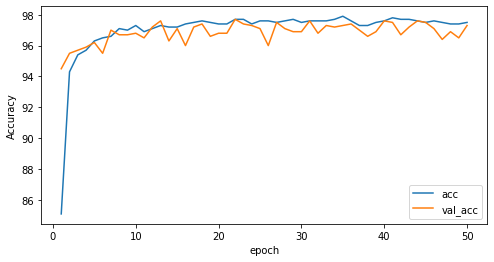

Done!


In [26]:
print("DECOY MNIST Simple CNN XIL -> HINTLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = HINTLoss(100, last_conv_specified=True, upsample=True) 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-HINT-reg100')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST -> CNN, XIL Loss HINT (downsample mask)

DECOY MNIST Simple CNN XIL -> HINTLoss (downsample expl maks):
Start training...
Epoch 2| accuracy: 95.8%, loss: 0.024151 | Test Error: Acc: 96.2%, Avg loss: 0.006032
Epoch 4| accuracy: 97.4%, loss: 0.020988 | Test Error: Acc: 96.9%, Avg loss: 0.005992
Epoch 6| accuracy: 97.8%, loss: 0.019549 | Test Error: Acc: 97.9%, Avg loss: 0.005953
Epoch 8| accuracy: 98.1%, loss: 0.019411 | Test Error: Acc: 96.5%, Avg loss: 0.006005
Epoch 10| accuracy: 98.5%, loss: 0.018894 | Test Error: Acc: 96.7%, Avg loss: 0.006006
Epoch 12| accuracy: 98.5%, loss: 0.018558 | Test Error: Acc: 95.3%, Avg loss: 0.006064
Epoch 14| accuracy: 98.4%, loss: 0.018116 | Test Error: Acc: 94.4%, Avg loss: 0.006095
Epoch 16| accuracy: 98.6%, loss: 0.018198 | Test Error: Acc: 96.1%, Avg loss: 0.006036
Epoch 18| accuracy: 98.7%, loss: 0.018602 | Test Error: Acc: 94.8%, Avg loss: 0.006083
Epoch 20| accuracy: 98.6%, loss: 0.019062 | Test Error: Acc: 91.6%, Avg loss: 0.006205
Epoch 22| accuracy: 98.8%, loss: 0.018453 | Test Erro

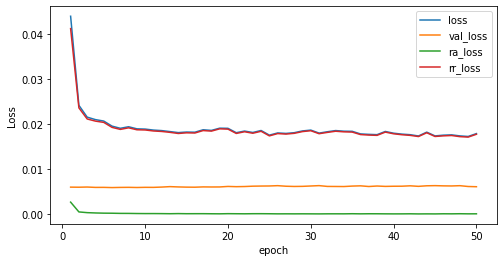

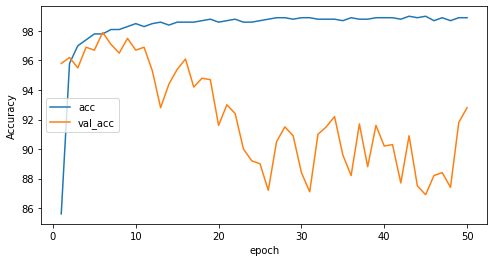

Done!


In [27]:
print("DECOY MNIST Simple CNN XIL -> HINTLoss (downsample expl maks):")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = HINTLoss(100, last_conv_specified=True) 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-HINT_d-reg100')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

As we can see above decoy MNIST is not difficult enough to fool a simple CNN. We need s more difficult benchmark to evalute the functionality of XIL on a CNN. See next notebook Fashion MNIST. Interestingly, the decoy MNIST from Rieger et. al 2020 (we call it Decoy MNIST-Rieger) is more difficult, because the test set does not set the squares randomly, but reversers the gray color compared to the train set.

### DECOY MNIST-RIEGER -> no XIL

Loading dataset from existing file!
Train set


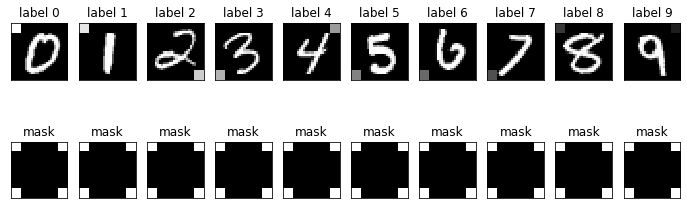

Val set


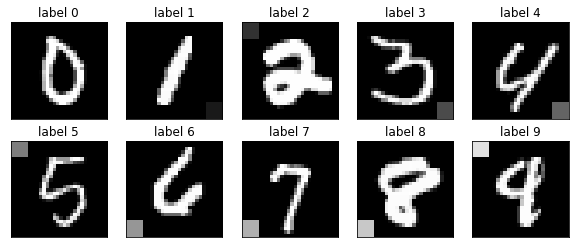

In [28]:
# Load dataloaders
train_dataloader, val_dataloader = decoy_mnist_rieger(shuffle=True, batch_size=256)

# show image and explanation grid training
print("Train set")
util.show_img_expl_grid_mnist(train_dataloader)
# show image and explanation grid val set
print("Val set")
util.show_img_grid_mnist(val_dataloader)


DECOY MNIST-RIEGER Simple CNN no XIL -> CrossEntropyLoss:
Start training...
Epoch 2| accuracy: 98.3%, loss: 0.000214 | Test Error: Acc: 98.6%, Avg loss: 0.005944
Epoch 4| accuracy: 99.3%, loss: 0.000091 | Test Error: Acc: 97.4%, Avg loss: 0.006009
Epoch 6| accuracy: 99.6%, loss: 0.000048 | Test Error: Acc: 82.2%, Avg loss: 0.006573
Epoch 8| accuracy: 99.8%, loss: 0.000028 | Test Error: Acc: 75.1%, Avg loss: 0.006834
Epoch 10| accuracy: 99.9%, loss: 0.000021 | Test Error: Acc: 70.3%, Avg loss: 0.007040
Epoch 12| accuracy: 99.8%, loss: 0.000026 | Test Error: Acc: 68.5%, Avg loss: 0.007100
Epoch 14| accuracy: 99.9%, loss: 0.000018 | Test Error: Acc: 66.3%, Avg loss: 0.007174
Epoch 16| accuracy: 99.9%, loss: 0.000011 | Test Error: Acc: 59.0%, Avg loss: 0.007492
Epoch 18| accuracy: 99.9%, loss: 0.000017 | Test Error: Acc: 56.8%, Avg loss: 0.007589
Epoch 20| accuracy: 99.8%, loss: 0.000017 | Test Error: Acc: 55.0%, Avg loss: 0.007624
Epoch 22| accuracy: 100.0%, loss: 0.000006 | Test Error: A

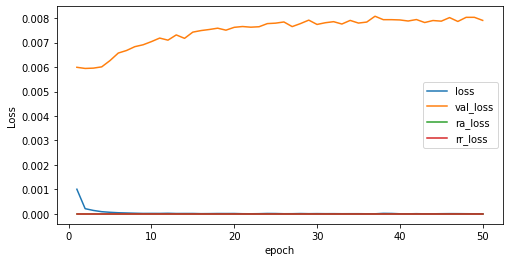

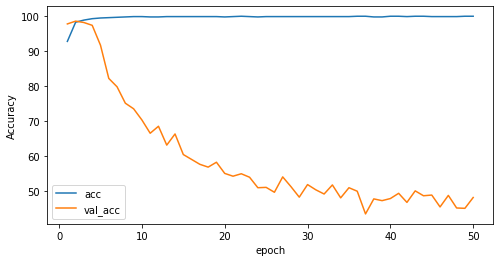

Done!


In [29]:
print("DECOY MNIST-RIEGER Simple CNN no XIL -> CrossEntropyLoss:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = nn.CrossEntropyLoss() # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-Rieger-CEL')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST-RIEGER CNN -> XIL Loss RRR

DECOY MNIST-RIEGER Simple CNN XIL -> RRR:
Start training...
Epoch 2| accuracy: 97.3%, loss: 0.000460 | Test Error: Acc: 98.0%, Avg loss: 0.005990
Epoch 4| accuracy: 98.4%, loss: 0.000251 | Test Error: Acc: 98.6%, Avg loss: 0.005946
Epoch 6| accuracy: 98.7%, loss: 0.000191 | Test Error: Acc: 98.8%, Avg loss: 0.005917
Epoch 8| accuracy: 99.0%, loss: 0.000150 | Test Error: Acc: 99.0%, Avg loss: 0.005910
Epoch 10| accuracy: 99.2%, loss: 0.000126 | Test Error: Acc: 99.2%, Avg loss: 0.005899
Epoch 12| accuracy: 99.4%, loss: 0.000099 | Test Error: Acc: 98.9%, Avg loss: 0.005905
Epoch 14| accuracy: 99.4%, loss: 0.000087 | Test Error: Acc: 99.1%, Avg loss: 0.005901
Epoch 16| accuracy: 99.5%, loss: 0.000075 | Test Error: Acc: 99.0%, Avg loss: 0.005911
Epoch 18| accuracy: 99.6%, loss: 0.000068 | Test Error: Acc: 99.0%, Avg loss: 0.005896
Epoch 20| accuracy: 99.6%, loss: 0.000070 | Test Error: Acc: 99.0%, Avg loss: 0.005898
Epoch 22| accuracy: 99.6%, loss: 0.000060 | Test Error: Acc: 98.9%, Avg lo

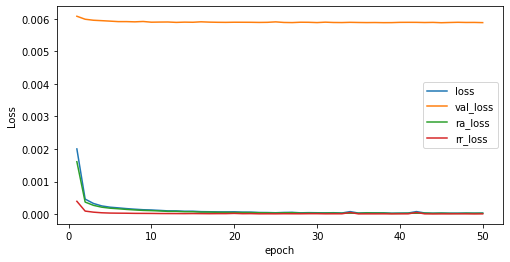

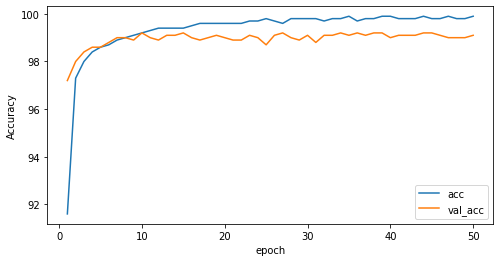

Done!


In [30]:
print("DECOY MNIST-RIEGER Simple CNN XIL -> RRR:")
util.set_seed(SEED)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = RRRLoss(10) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-Rieger-RRR-reg10')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")

### DECOY MNIST-RIEGER CNN -> XIL Loss CDEP

DECOY MNIST-RIEGER Simple CNN XIL -> CDEP:
Start training...
Epoch 2| accuracy: 91.4%, loss: 0.001142 | Test Error: Acc: 93.9%, Avg loss: 0.006233
Epoch 4| accuracy: 95.7%, loss: 0.000559 | Test Error: Acc: 96.3%, Avg loss: 0.006084
Epoch 6| accuracy: 96.9%, loss: 0.000401 | Test Error: Acc: 96.7%, Avg loss: 0.006043
Epoch 8| accuracy: 97.4%, loss: 0.000330 | Test Error: Acc: 97.4%, Avg loss: 0.005995
Epoch 10| accuracy: 97.8%, loss: 0.000272 | Test Error: Acc: 97.8%, Avg loss: 0.005973
Epoch 12| accuracy: 98.1%, loss: 0.000237 | Test Error: Acc: 97.5%, Avg loss: 0.005974
Epoch 14| accuracy: 98.4%, loss: 0.000202 | Test Error: Acc: 98.3%, Avg loss: 0.005951
Epoch 16| accuracy: 98.7%, loss: 0.000176 | Test Error: Acc: 98.4%, Avg loss: 0.005946
Epoch 18| accuracy: 98.8%, loss: 0.000154 | Test Error: Acc: 98.2%, Avg loss: 0.005945
Epoch 20| accuracy: 98.9%, loss: 0.000142 | Test Error: Acc: 97.8%, Avg loss: 0.005965
Epoch 22| accuracy: 99.1%, loss: 0.000117 | Test Error: Acc: 97.7%, Avg l

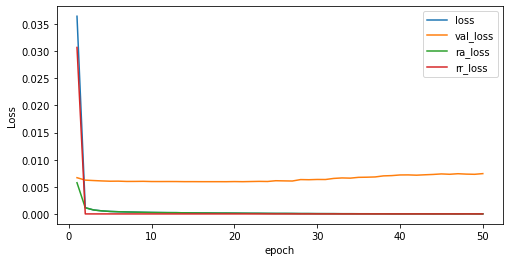

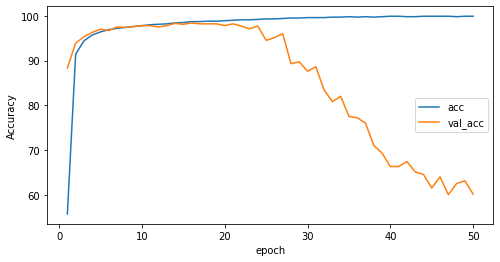

Done!


In [31]:
print("DECOY MNIST-RIEGER Simple CNN XIL -> CDEP:")
util.set_seed(60)
# initalize model, loss and optimizer
model = dnns.SimpleConvNet().to(device)
loss_fn = CDEPLoss(1000) # param sets the regularizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Build Learner
learner = Learner(model, loss_fn, optimizer, device, 'SimpleCNN-DecoyMnist-Rieger-CDEP-reg1000')
# training routine
learner.fit(train_dataloader, val_dataloader, EPOCHS, save_best=SAVE_BEST, verbose_after_n_epochs=VERBOSE_AFTER_N_EPOCHS)
# show train, val acc and loss
learner.plot_loss_acc()
#learner.validation_statistics(val_dataloader)

## if you want to load the best model according to val set
# learner.load('SimpleCNN-DecoyMnist-CEL.pt')
## evalute on val set
# learner.score(val_dataloader, F.cross_entropy)
print("Done!")